# <center>LoanTap Business Case Study</center>   

### Problem Definition:
   The objective of LoanTap is to determine whether a credit line should be extended to an individual based on their attributes. The key challenge is to minimize the risk of non-performing assets (NPAs) by flagging potential defaulters, while ensuring loans are disbursed to as many eligible customers as possible to maximize interest earnings.

### 1. Data cleaning and exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc,roc_auc_score, ConfusionMatrixDisplay,
                             f1_score, recall_score,
                             precision_score, precision_recall_curve,
                             average_precision_score, classification_report)

In [2]:
df = pd.read_csv("logistic_regression.csv")

In [3]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
#shape of data
df.shape

(396030, 27)

- **A quick overview of the data indicates it consists of 396030 rows and 27 columns.**

In [5]:
# To check data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [6]:
#Checking columns with object(category) datatype
cat_cols = df.columns[df.dtypes == 'object']
cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [7]:
# Number of unique values in all non-numeric columns
for col in cat_cols:
    print(f"No. of unique values in {col}: {df[col].nunique()}")

No. of unique values in term: 2
No. of unique values in grade: 7
No. of unique values in sub_grade: 35
No. of unique values in emp_title: 173105
No. of unique values in emp_length: 11
No. of unique values in home_ownership: 6
No. of unique values in verification_status: 3
No. of unique values in issue_d: 115
No. of unique values in loan_status: 2
No. of unique values in purpose: 14
No. of unique values in title: 48817
No. of unique values in earliest_cr_line: 684
No. of unique values in initial_list_status: 2
No. of unique values in application_type: 3
No. of unique values in address: 393700


In [8]:
df[['earliest_cr_line','issue_d']].head()

,earliest_cr_line,issue_d
0,Jun-1990,Jan-2015
1,Jul-2004,Jan-2015
2,Aug-2007,Jan-2015
3,Sep-2006,Nov-2014
4,Mar-1999,Apr-2013


In [9]:
#converting 'earliest_cr_line' and 'issue_d' columns from object type to datetime type
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [10]:
df['emp_length'].value_counts()

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

In [11]:
#Convert employment length to numeric
d = {'10+ years':10, '4 years':4, '< 1 year':0,
     '6 years':6, '9 years':9,'2 years':2, '3 years':3,
     '8 years':8, '7 years':7, '5 years':5, '1 year':1}
df['emp_length'] = df['emp_length'].replace(d)


In [12]:
#Convert columns with less number of unique values to categorical columns
cat_cols = ['term', 'grade','sub_grade','home_ownership',
            'verification_status','loan_status','purpose',
            'initial_list_status','application_type']

df[cat_cols] = df[cat_cols].astype('category')


### 2. Univariate Analysis for Categorical Variables :

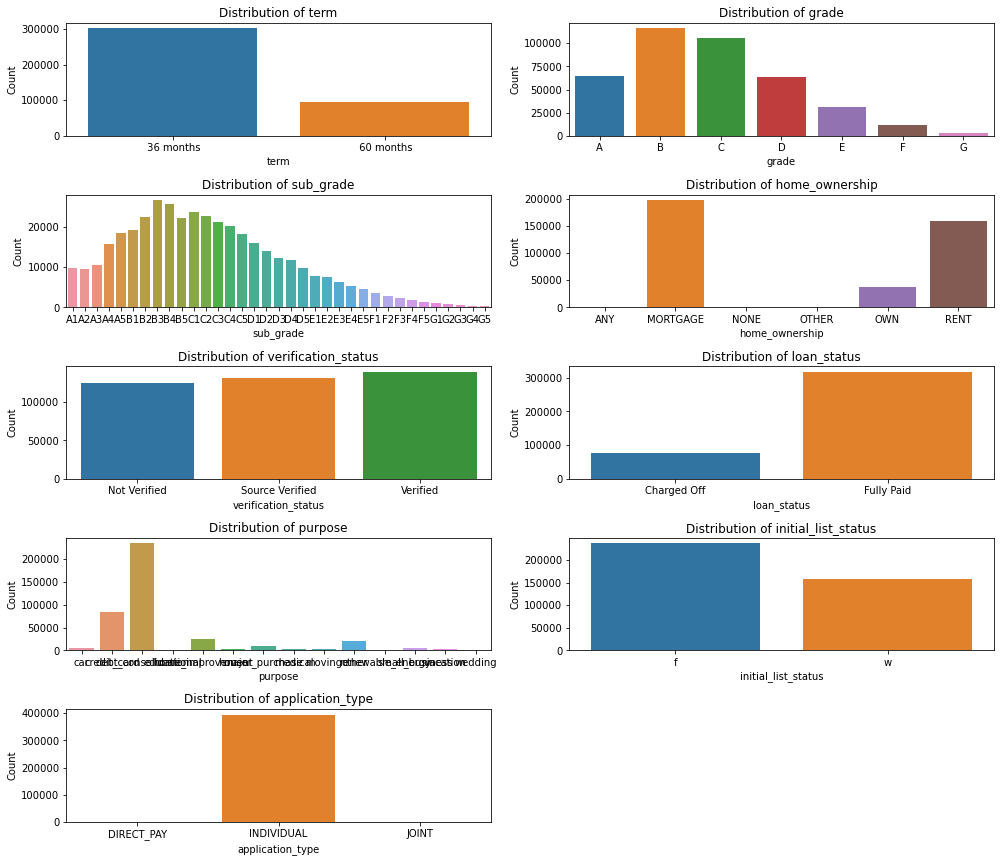

In [13]:
plt.figure(figsize=(14,14))
i=1
for col in cat_cols:    
    ax=plt.subplot(6,2,i)
    sns.countplot(data=df,x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    i += 1

plt.tight_layout()
plt.show();


#### 1. **term**
   - **Range**: 36 months or 60 months
   - **Distribution**: The majority of loans are for 36 months, with fewer loans for 60 months.
   - **Interpretation**: Borrowers prefer shorter-term loans, likely due to lower overall interest costs or faster repayment schedules. Loans with 60-month terms are less common, possibly indicating a preference for quicker repayment.

#### 2. **grade**
   - **Range**: A to G
   - **Distribution**: Most loans fall in grades A, B, C, and D, while grades E, F, and G have significantly fewer loans.
   - **Interpretation**: Grades B and C are the most common, likely representing mid-tier creditworthiness. The lower number of loans in grades E, F, and G suggests that fewer borrowers have poor creditworthiness, or loans in these categories are less frequently approved.

#### 3. **sub_grade**
   - **Range**: A1 to G5
   - **Distribution**: The distribution is broader than for the main grades, with sub-grades B3, B4, and C1 being the most common.
   - **Interpretation**: The sub-grades provide a more granular view of creditworthiness. While the main grades highlight broader trends, the sub-grades show a tendency toward slightly better creditworthiness within each main grade.

#### 4. **home_ownership**
   - **Range**: ANY, MORTGAGE, NONE, OTHER, OWN, RENT
   - **Distribution**: Most borrowers either have a mortgage or rent. Fewer borrowers own their homes outright.
   - **Interpretation**: Borrowers with mortgages dominate, which may indicate higher borrowing for property purchases. Renters also form a large part of the borrower population, likely because they may need additional financing to cover housing expenses.

#### 5. **loan_status**
   - **Range**: Charged Off, Fully Paid
   - **Distribution**: A large number of loans are fully paid, with fewer loans being charged off.
   - **Interpretation**: Most loans in the dataset are successfully repaid. The lower number of charged-off loans indicates that defaults are less common, reflecting a generally lower risk in the borrower population.

#### 6. **verification_status**
   - **Range**: Not Verified, Source Verified, Verified
   - **Distribution**: Roughly equal distribution across the three categories, with a slight edge to “Source Verified” and “Verified.”
   - **Interpretation**: There is a balanced verification process, with many loans undergoing verification before approval. The similar count across categories suggests no strong bias in approval rates based on verification.

#### 7. **purpose**
   - **Range**: Various purposes such as credit_card, debt_consolidation, home_improvement, etc.
   - **Distribution**: Debt consolidation is by far the most common purpose, followed by credit card refinancing.
   - **Interpretation**: Borrowers predominantly take out loans for consolidating debt, indicating a high level of existing financial obligations. This is followed by credit card refinancing, showing that borrowers are likely trying to manage high-interest debts through loans with lower rates.

#### 8. **initial_list_status**
   - **Range**: f, w
   - **Distribution**:  Loan's first category "f" is more common than "w."
   - **Interpretation**: The dataset shows a higher count for "f" category loans, possibly indicating a difference in how loans are initially listed for funding.

#### 9. **application_type**
   - **Range**: DIRECT_PAY, INDIVIDUAL, JOINT
   - **Distribution**: Most loans are categorized as "INDIVIDUAL," with a few "JOINT" applications and very few "DIRECT_PAY."
   - **Interpretation**: The majority of borrowers are applying for loans individually. Joint applications are less common, indicating that fewer borrowers are co-signing or applying for loans with another person.


**10. emp_title**

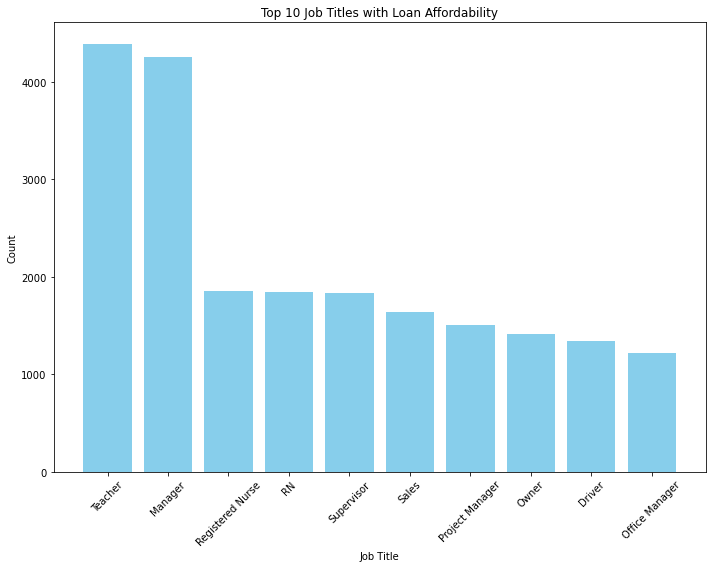

In [14]:
plt.figure(figsize=(10, 8))
plt.bar(df.emp_title.value_counts()[:10].index, df.emp_title.value_counts()[:10], color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 10 Job Titles with Loan Affordability")
plt.xlabel("Job Title")
plt.ylabel("Count")
plt.tight_layout()  
plt.show()

**Note:**
- **Employment Titles**: Applicants with job titles like "Manager" and "Teacher" are among the top segments receiving loans, indicating stable income and lower perceived risk.  

### 3. Univariate Analysis for Continuous Variables:

In [15]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

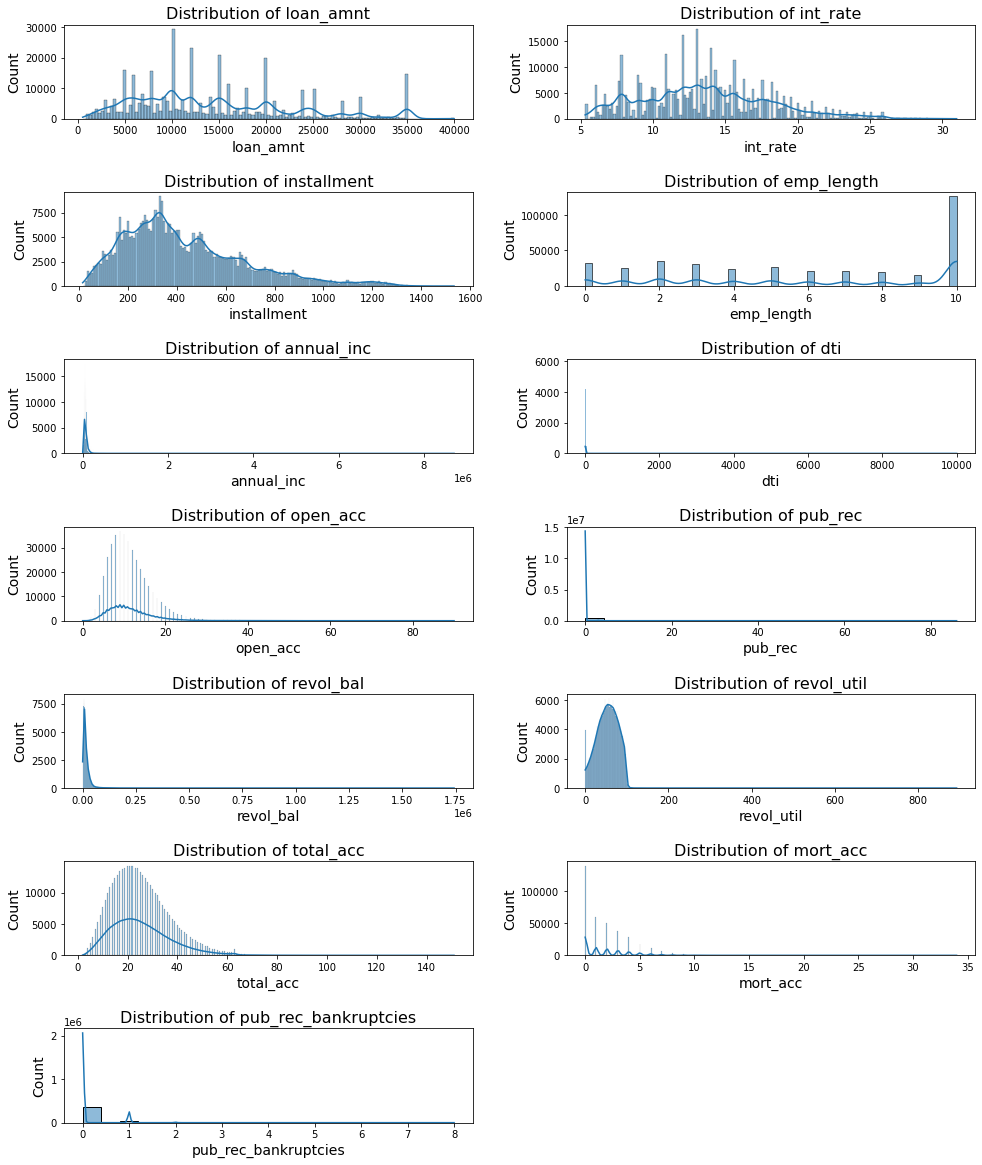

In [16]:
plt.figure(figsize=(14, 30))  # Increase figure size (width, height)
i = 1
for col in num_cols:
    ax = plt.subplot(len(num_cols), 2, i) 
    sns.histplot(data=df[col], kde=True)
    plt.title(f'Distribution of {col}', fontsize=16) 
    plt.xlabel(col, fontsize=14)  
    plt.ylabel('Count', fontsize=14)  
    i += 1

plt.tight_layout(pad=2.0)  # Add padding between plots to avoid overlap
plt.show();

#### 1. **loan_amnt**
   - **Range**: 500 to 40,000
   - **Distribution**: The distribution shows peaks at certain loan amounts, such as 10,000, 15,000, and 20,000.
   - **Interpretation**: Borrowers tend to prefer round loan amounts, with most loans being within the mid-range. The upper limit of 40,000 is rare, indicating that higher loan amounts are less common.

#### 2. **int_rate (Interest Rate)**
   - **Range**: 5% to 35%
   - **Distribution**: The distribution is somewhat uniform, with a slight peak between 10% and 15%.
   - **Interpretation**: Interest rates are spread across a wide range, with most loans falling within 10-15%. This suggests that borrowers are offered varied interest rates based on their credit profiles, and a significant portion of loans has moderate interest rates.

#### 3. **installment**
   - **Range**: 0 to 1,600
   - **Distribution**: Installments are concentrated around mid-levels (300 to 600), with a few loans having very high installment amounts.
   - **Interpretation**: Most borrowers have moderate monthly installments, indicating a preference for affordable, medium-term repayments. Very high installment loans are relatively rare.

#### 4. **annual_inc (Annual Income)**
   - **Range**: 0 to ~10,000,000 (with most data up to 300,000)
   - **Distribution**: Highly skewed with most values between 0 and 200,000. There are a few extreme outliers in the millions.
   - **Interpretation**: The majority of borrowers have incomes below 200,000, and the distribution is heavily skewed due to a few extreme income outliers. This skewness may require attention during model building to avoid bias from outliers.

#### 5. **dti (Debt-to-Income Ratio)**
   - **Range**: 0 to 1,000
   - **Distribution**: The distribution is heavily skewed toward lower values, with most borrowers having a DTI below 40.
   - **Interpretation**: Most borrowers maintain a moderate debt-to-income ratio, with lower DTI values indicating a healthier financial status. High DTIs are rare, indicating that higher-risk borrowers with large amounts of debt are uncommon.

#### 6. **open_acc (Number of Open Credit Lines)**
   - **Range**: 0 to 90
   - **Distribution**: The majority of borrowers have between 5 and 20 open credit accounts.
   - **Interpretation**: Most borrowers have a moderate number of open credit lines, with few having an exceptionally high number. This suggests that the credit utilization is balanced for most individuals.

#### 7. **pub_rec (Public Record Bankruptcies)**
   - **Range**: 0 to 10
   - **Distribution**: Almost all borrowers have 0 public records, with only a small number having 1 or more.
   - **Interpretation**: Very few borrowers have bankruptcies or other public records, indicating that the borrower pool is generally low-risk in terms of prior financial distress.

#### 8. **revol_bal (Revolving Balance)**
   - **Range**: 0 to 1,500,000
   - **Distribution**: The revolving balance is skewed, with most values below 100,000, but there are some extreme outliers.
   - **Interpretation**: Most borrowers have a manageable revolving balance, but there are a few extreme cases with very high balances. These outliers could represent borrowers with significantly higher debt levels.

#### 9. **revol_util (Revolving Credit Utilization)**
   - **Range**: 0 to 200%
   - **Distribution**: Most borrowers have revolving utilization between 0% and 100%, with some going slightly over 100%.
   - **Interpretation**: The majority of borrowers have a reasonable credit utilization rate (below 50%). A few borrowers have a high utilization, indicating higher credit risk.

#### 10. **total_acc (Total Number of Credit Lines)**
   - **Range**: 0 to 180
   - **Distribution**: The distribution is concentrated between 10 and 40 credit lines.
   - **Interpretation**: Most borrowers have between 10 and 40 credit accounts, indicating an established credit history. Very high total account numbers are rare.

#### 11. **mort_acc (Number of Mortgage Accounts)**
   - **Range**: 0 to 35
   - **Distribution**: The majority of borrowers have 0 to 5 mortgage accounts, with very few having more than that.
   - **Interpretation**: Most borrowers either have no mortgages or only a few. This suggests that mortgage borrowers form a smaller subset of the dataset.

#### 12. **pub_rec_bankruptcies**
   - **Range**: 0 to 7
   - **Distribution**: Almost all borrowers have 0 or 1 bankruptcy records, with very few having more.
   - **Interpretation**: The majority of the borrowers have no bankruptcy history, indicating a relatively stable credit history among most borrowers.


### 4. Bivariate Analysis

#### 1. **loan_status vs loan_amount**

In [17]:
df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

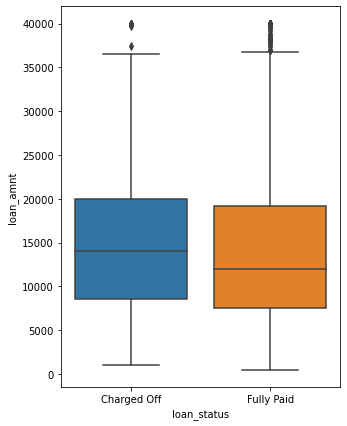

In [18]:
plt.figure(figsize=(5,7))
sns.boxplot(x=df['loan_status'],y=df['loan_amnt'])

#### Key Insights:
- Both "Charged Off" and "Fully Paid" loans have a similar distribution in terms of loan amounts, though loans that are "Charged Off" seem to have a slightly higher median amount.
- There are more high-value outliers in the "Fully Paid" category.
- This suggests that larger loan amounts might be slightly more likely to result in "Charged Off" status, but the difference is not very pronounced.

**2. loan_status vs int_rate**

In [19]:

df.groupby(by = "loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15.882587,4.388135,5.32,12.99,15.61,18.64,30.99
Fully Paid,318357.0,13.092105,4.319105,5.32,9.91,12.99,15.61,30.99


<AxesSubplot:xlabel='loan_status', ylabel='int_rate'>

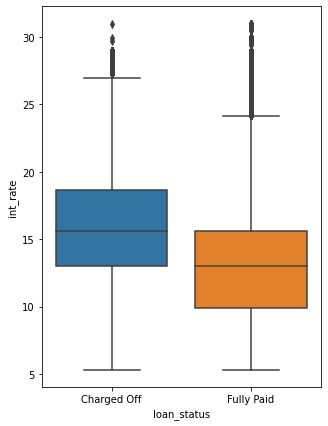

In [20]:
plt.figure(figsize = (5,7))
sns.boxplot(x = df['loan_status'],
            y = df['int_rate'])

#### Key Insights:
   - **Range and Distribution**: Interest rates for both "Charged Off" and "Fully Paid" loans range from approximately 5% to 30%, with medians around 10-15%.
   - **Interpretation**: Charged-off loans tend to have slightly higher interest rates on average compared to fully paid loans, which could indicate that higher interest rates may be associated with a greater risk of default.

**3. loan_status vs annual_inc**

In [21]:
df.groupby(by = "loan_status")["annual_inc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,67535.537710,58303.457136,0.0,42000.00,59000.0,80000.0,8706582.0
Fully Paid,318357.0,75829.951566,62315.991907,600.0,46050.53,65000.0,90000.0,7600000.0


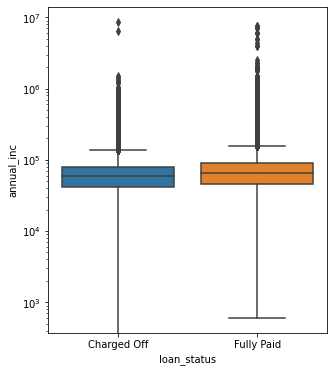

In [22]:
plt.figure(figsize = (5,6))
sns.boxplot(x = df['loan_status'],
            y = df['annual_inc'])
plt.yscale('log')

**Annual_inc by loan_status:**

- Range: Annual income spans a broad range from 0 to over $10^6$.
- Distribution: Both groups show similar distributions with numerous outliers. The median annual income for the "Fully Paid" group is slightly higher than for the "Charged Off" group.
- Interpretation: Borrowers who fully repay their loans have slightly higher annual incomes, though the difference is not pronounced.

**4. loan_status vs revol_bal**

In [23]:
df.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15390.454701,18203.387930,0.0,6150.0,11277.0,19485.0,1030826.0
Fully Paid,318357.0,15955.327918,21132.193457,0.0,5992.0,11158.0,19657.0,1743266.0


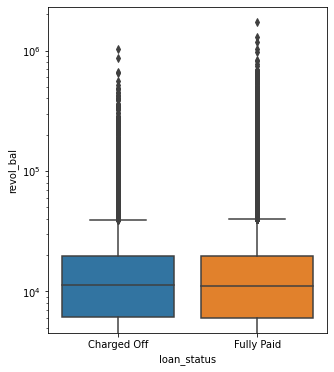

In [24]:
plt.figure(figsize = (5,6))
sns.boxplot(x = df['loan_status'],
            y = df['revol_bal'])
plt.yscale('log')

**revol_bal (revolving balance) by loan_status:**
- Range: Revolving balances (e.g., credit card balances) range from 0 to over $10^6$.
- Distribution: The "Fully Paid" group has a slightly higher median revolving balance than the "Charged Off" group.
- Interpretation: Higher revolving balances are somewhat more associated with successful loan repayment.

**5. loan_status vs dti**

In [25]:
df.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,19.656346,36.781068,0.0,13.33,19.34,25.55,9999.0
Fully Paid,318357.0,16.824010,8.500979,0.0,10.87,16.34,22.29,1622.0


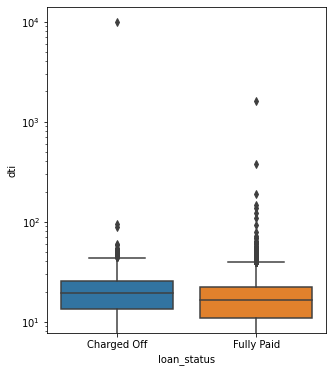

In [26]:
plt.figure(figsize = (5,6))
sns.boxplot(x = df['loan_status'],
            y = df['dti'])
plt.yscale('log')


####  **key Insights**
   - **Range and Distribution**: DTI values range from around 0 to a few hundred, though most are below 50. Charged-off loans show a slightly higher median DTI than fully paid loans.
   - **Interpretation**: A higher debt-to-income ratio appears to be associated with a higher risk of default, indicating that borrowers with higher relative debt may be at greater risk.

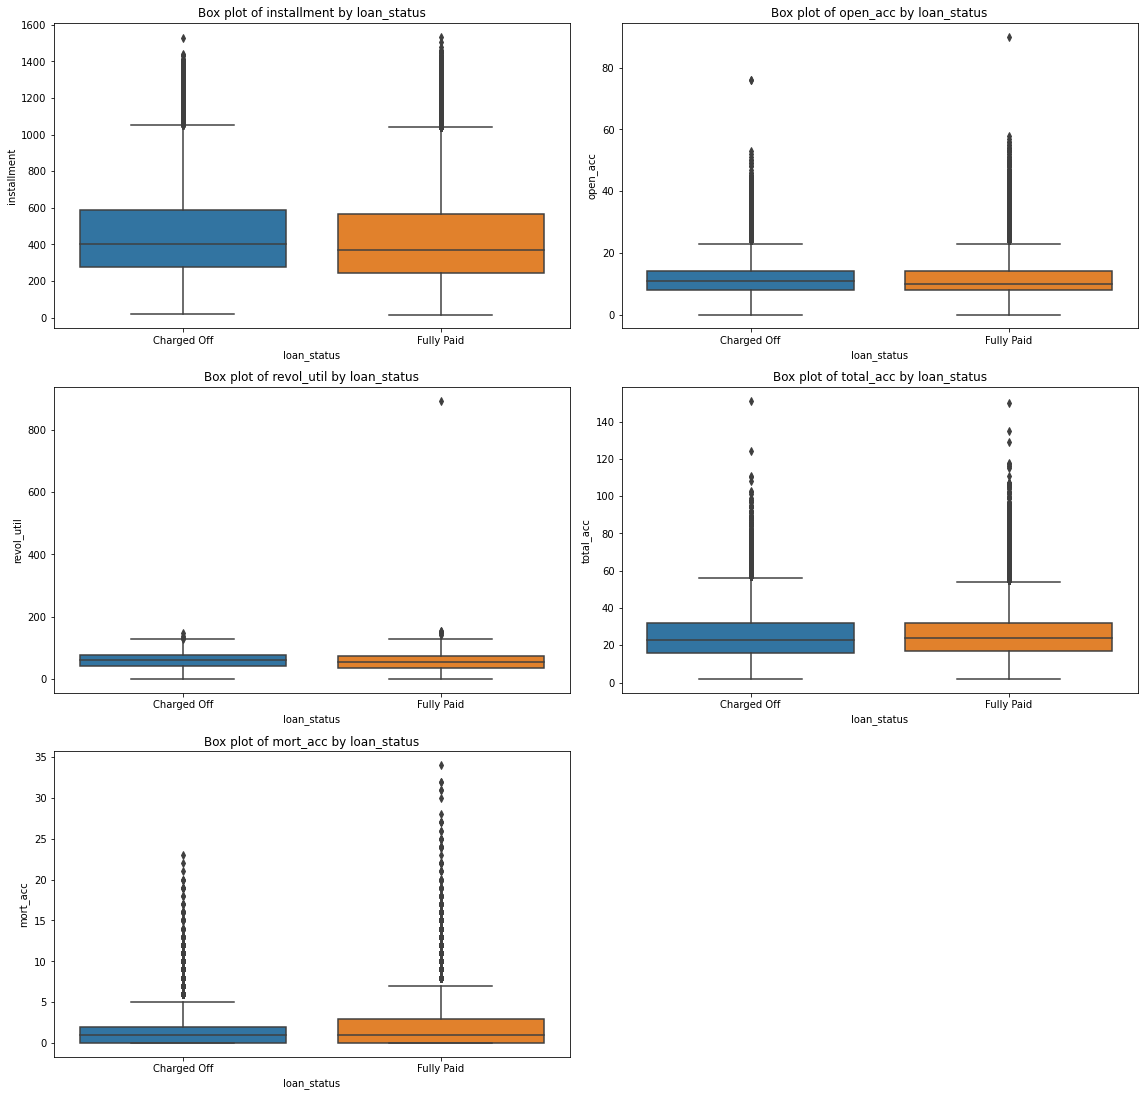

In [27]:
numerical_columns = [ 'installment', 
        'open_acc', 'revol_util', 'total_acc',
       'mort_acc']

# Categorical column
cat_column = 'loan_status'

# Set the figure size
plt.figure(figsize=(16, 25))

# Loop through each numerical column and create a box plot
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, i)  # Arrange plots in a single column
    sns.boxplot(x=cat_column, y=col, data=df)
    plt.title(f'Box plot of {col} by {cat_column}')
    #plt.yscale('log')
    plt.tight_layout()

plt.show()


#### 6. **Installment**
   - **Range and Distribution**: Installment amounts for both loan statuses range from around 0 to over 1500, with a slightly lower median for fully paid loans.
   - **Interpretation**: Higher installment amounts appear to be slightly more common in charged-off loans, suggesting that borrowers with higher installment obligations might be at higher risk of default.

#### 7. **Open Accounts (open_acc)**
   - **Range and Distribution**: The number of open accounts ranges from 0 to around 60, with medians around 10-15 for both loan statuses.
   - **Interpretation**: There isn’t a significant difference in open accounts between the two groups, implying that the total number of open accounts may not be a strong indicator of loan repayment risk.

#### 8. **Revolving Utilization (revol_util)**
   - **Range and Distribution**: Revolving utilization ratios vary widely, but most values are concentrated between 0% and 100%.
   - **Interpretation**: Charged-off loans show a slightly higher median revolving utilization, suggesting that high utilization rates could correlate with higher default risk.

#### 9. **Total Accounts (total_acc)**
   - **Range and Distribution**: The total number of accounts varies from a few to over 100, with a median around 20 for both loan statuses.
   - **Interpretation**: Both charged-off and fully paid loans have a similar distribution, so the total number of accounts does not seem to be a strong predictor of loan status.

#### 10. **Mortgage Accounts (mort_acc)**
   - **Range and Distribution**: Mortgage accounts range from 0 to around 30, with a similar distribution in both groups.
   - **Interpretation**: This feature appears to be fairly balanced across loan statuses, suggesting that the number of mortgage accounts might not have a significant effect on the likelihood of default.


**11. term vs loan_status**

In [28]:
term_status = pd.crosstab(df['term'],df['loan_status'],normalize = "index",margins = True) *100
term_status

loan_status,Charged Off,Fully Paid
term,,
36 months,15.774573,84.225427
60 months,31.941505,68.058495
All,19.612908,80.387092


<AxesSubplot:xlabel='term'>

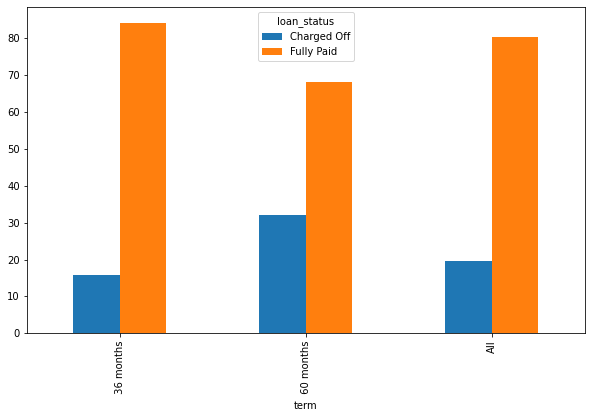

In [29]:
term_status.plot(kind="bar", figsize=(10, 6))

#### Key Insights:
   - **Distribution**: The bar plot shows the distribution of loan status (Charged Off and Fully Paid) across two loan terms: 36 months and 60 months.
   - **Interpretation**:
      - For both loan terms, there are significantly more Fully Paid loans than Charged Off loans.
      - However, the proportion of Charged Off loans is higher for 60-month terms compared to 36-month terms, suggesting that longer loan terms might be associated with a greater risk of default.
      - This insight can inform loan structuring policies, where shorter terms might reduce the likelihood of default.

#### 12. grade vs loan_status

In [30]:
#grade vs loan_status
grade_status= pd.crosstab(index = df["grade"],
            columns= df["loan_status"],normalize= "index") *100
grade_status

loan_status,Charged Off,Fully Paid
grade,,
A,6.287878,93.712122
B,12.573049,87.426951
C,21.180900,78.819100
D,28.867829,71.132171
E,37.363440,62.636560
F,42.787971,57.212029
G,47.838900,52.161100


<AxesSubplot:xlabel='grade'>

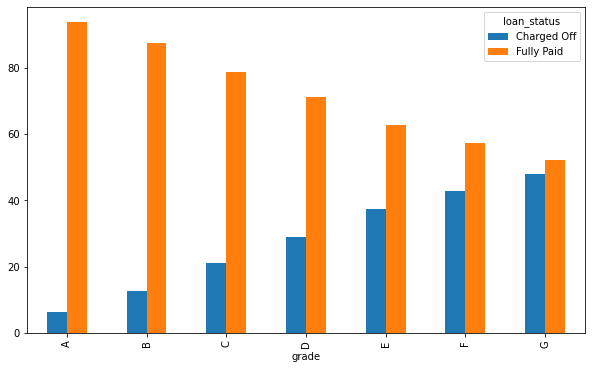

In [31]:
grade_status.plot(kind = "bar",figsize=(10,6))

#####  **Key Insights**
   - **Range**: This bar plot shows loan status across different loan grades (A to G).
   - **Interpretation**:
      - The majority of loans in higher grades (A, B, and C) are Fully Paid, while the proportion of Charged Off loans increases as the grade decreases (from D onwards).
      - Lower grades (E, F, and G) have a visibly higher proportion of Charged Off loans.
      - This suggests that lower-grade loans (associated with potentially higher risk borrowers) are more likely to default, which aligns with expectations since grades often reflect credit risk.
      .



#### 13. **subgrade vs loan_status**

In [32]:
sub_status = pd.crosstab(index = df["sub_grade"], columns = df["loan_status"] , normalize = "index") * 100
sub_status

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,2.867715,97.132285
A2,4.818647,95.181353
A3,5.805598,94.194402
A4,7.023877,92.976123
A5,8.490770,91.509230
B1,9.858200,90.141800
B2,10.851300,89.148700
B3,12.335397,87.664603
B4,13.839303,86.160697


<AxesSubplot:xlabel='sub_grade'>

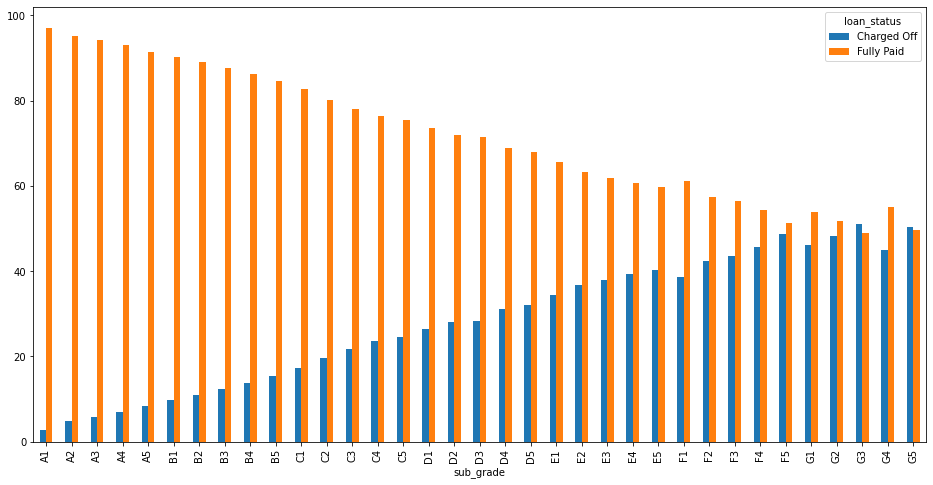

In [33]:
sub_status.plot(kind = 'bar',figsize = (16,8))

The plot indicates that higher sub-grades (A1 to B4) have significantly more **Fully Paid** loans, suggesting better creditworthiness. As the sub-grades decrease (C1 to G5), the proportion of **Charged Off** loans increases, reflecting higher default rates. The range shows a clear relationship between sub-grade and loan status, with **A1-A5** having the best repayment rates and **D5-G5** exhibiting higher default risks.

#### 14. **emp_length vs loan_status**

In [34]:
length_status = pd.crosstab(df['emp_length'],df['loan_status'])
length_status

loan_status,Charged Off,Fully Paid
emp_length,,
0.0,6563,25162
1.0,5154,20728
2.0,6924,28903
3.0,6182,25483
4.0,4608,19344
5.0,5092,21403
6.0,3943,16898
7.0,4055,16764
8.0,3829,15339


Text(0.5, 0, 'Emp_length in years')

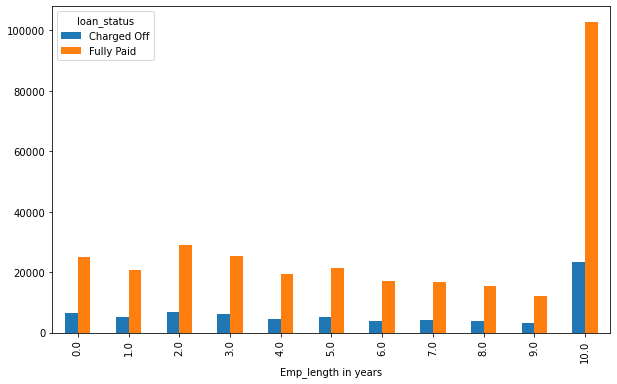

In [35]:
length_status.plot(kind = 'bar',figsize =(10,6))
plt.xlabel('Emp_length in years')

**Interpretation:** <br>
The plot shows that applicants with longer employment lengths, especially **10+ years**, are more likely to fully repay loans, as indicated by the higher number of **Fully Paid Loans**. Shorter employment lengths (0-3 years) have a higher proportion of **Charged Off Loans**, suggesting increased default risk in this group. Employment length appears to be a strong indicator of creditworthiness.

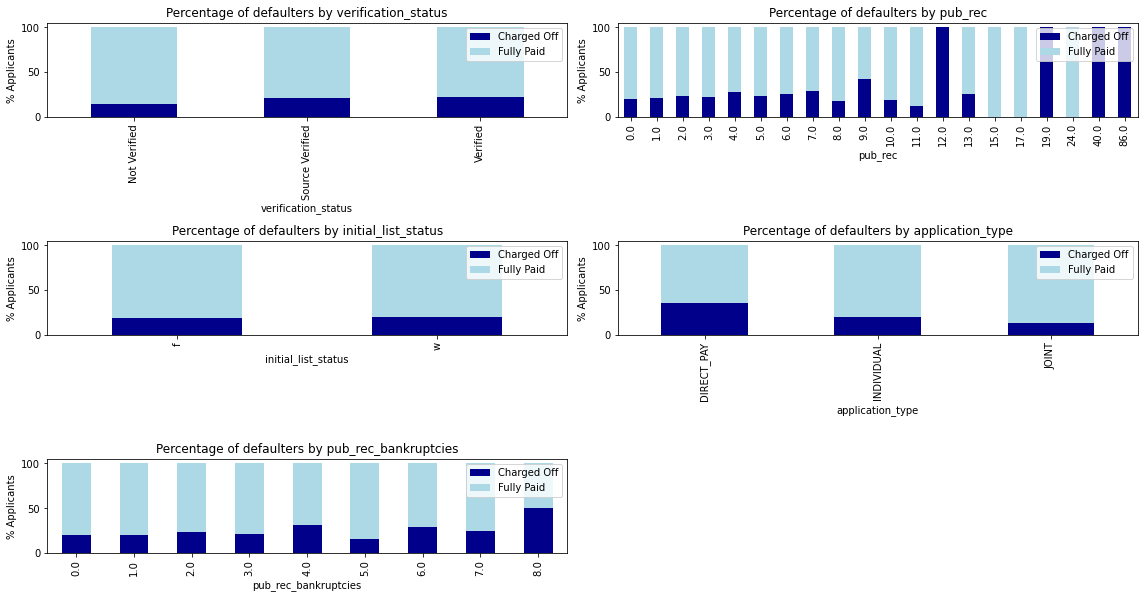

In [36]:
# List of categorical columns to plot using stacked barplot
cat_plot = ['verification_status', 'pub_rec', 'initial_list_status', 'application_type', 'pub_rec_bankruptcies']

plt.figure(figsize=(16, 20))  # Set figure size
i = 1  # Subplot index

for col in cat_plot:
    # Create a subplot
    ax = plt.subplot(7, 2, i)
    
    # Create pivot table and calculate percentages
    data = df.pivot_table(index=col, columns='loan_status', aggfunc='size',fill_value = 0)
    data = data.div(data.sum(axis=1), axis=0).multiply(100)  # Convert to percentages
    
    # Create stacked bar plot
    data.plot(kind='bar', stacked=True, color=['#00008b', '#add8e6'], ax=ax, legend=False)
    
    # Set plot labels and title
    plt.xlabel(col)
    plt.ylabel('% Applicants')
    plt.title(f'Percentage of defaulters by {col}')
    plt.legend(['Charged Off','Fully Paid'],loc = 'upper right')
    
    # Increment subplot index
    i += 1

#plt.legend(['Charged Off', 'Fully Paid'])
plt.tight_layout()  
plt.show()


#### 1. **Percentage of defaulters by verification_status** (Top left)
   - **Range**: The categories include "Not Verified," "Source Verified," and "Verified."
   - **Distribution**: Across all categories, "Fully Paid" dominates over "Charged Off." However, those loans that are "Not Verified" appear to have a slightly higher proportion of defaults compared to the other categories.
   - **Interpretation**: Applicants with unverified loan statuses have a higher likelihood of defaulting than those with some level of verification. Verification is an important factor in assessing loan risk.

#### 2. **Percentage of  defaulters by pub_rec** (Top right)
   - **Range**: This variable represents the number of derogatory public records (e.g., bankruptcies, liens). The values range from 0 to 20+.
   - **Distribution**: For lower values (0-2), the percentage of "Charged Off" loans is low, but it increases significantly for higher values (9-15). There’s a strong increase in defaults as public records increase.
   - **Interpretation**: A higher number of derogatory public records strongly correlates with loan defaults, as expected. Applicants with more public records are much riskier for lenders.

#### 3. **Percentage of  defaulters by initial_list_status** (Middle left)
   - **Range**: This field has two categories, represented as '1' and 'W'.
   - **Distribution**: Both categories show that the majority of loans are "Fully Paid." However, those with status '1' seem to have a slightly higher percentage of "Charged Off" loans.
   - **Interpretation**: This variable might be less predictive of defaults since the difference between the two groups is marginal. Still, status '1' could be slightly riskier.

#### 4. **Percentage of  defaulters by application_type** (Middle right)
   - **Range**: The categories include "Direct Pay," "Individual," and "Joint."
   - **Distribution**: Loans applied for by "Individuals" have a slightly higher default rate compared to the "Joint" and "Direct Pay" categories.
   - **Interpretation**: Joint applications seem to be less risky compared to individual applicants. This could imply that having more than one person responsible for loan repayment reduces the likelihood of default.

#### 5. **Percentage of  defaulters by pub_rec_bankruptcies** (Bottom left)
   - **Range**: The number of bankruptcies ranges from 0 to 8.
   - **Distribution**: The percentage of defaults increases with higher values, particularly from 4 bankruptcies onward.
   - **Interpretation**: The higher the number of bankruptcies on an applicant's record, the more likely they are to default. This aligns with expectations as more bankruptcies indicate a higher financial risk.

#### 6. **Percentage of  defaulters by emp_length** (Bottom right)
   - **Range**: Employment length ranges from 0 years to 10 years.
   - **Distribution**: The likelihood of defaults appears to decrease as employment length increases. Applicants with shorter employment lengths (0-2 years) have a higher percentage of "Charged Off" loans compared to those with longer employment histories.
   - **Interpretation**: Applicants with stable and longer employment histories tend to be less risky for lenders. Employment stability is a good predictor of loan repayment ability.


### 5. Multivariate analysis

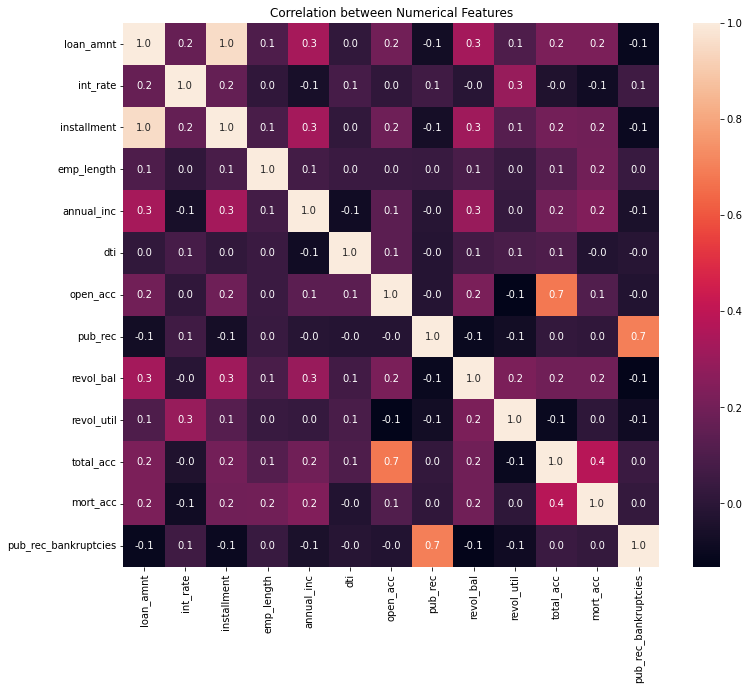

In [37]:
#Correlation between numerical features
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".1f")
plt.title('Correlation between Numerical Features')
plt.show()

#### Key Insights.
- loan_amnt and installment are perfectly correlated
- total_acc is highly correlated with open_acc
- pub_rec is highly correlated pub_rec_bankruptcies 
- total_acc is moderately correlated with mort_acc
- We can remove some of these correlated features to avoid multicolinearity

In [38]:
#Drop installment
df.drop(columns=['installment'], inplace=True)

##  Data Preprocessing

In [39]:
#To check missing values in terms of percentange
(df.isna().sum() / df.shape[0])*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

**Handling Missing values**

In [40]:
# Fill missing mort_acc values with the median mort_acc for each total_acc
mort_acc_median = df.groupby('total_acc')['mort_acc'].median()

# Define a function to fill missing values
def fill_mort_acc(row):
    if pd.isnull(row['mort_acc']):
        return mort_acc_median[row['total_acc']]
    else:
        return row['mort_acc']

# Apply the function to fill missing values
df['mort_acc'] = df.apply(fill_mort_acc, axis=1)

In [41]:
df.dropna(inplace=True)

In [42]:
(df.isna().sum() / df.shape[0])*100

loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
sub_grade               0.0
emp_title               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
title                   0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

In [43]:
#To check duplicate values
df.duplicated().sum()

0

### 6. Feature Engineering

In [44]:
median_pub_rec = df['pub_rec'].median()
median_mort_acc = df['mort_acc'].median()
median_pub_rec_bankruptcies = df['pub_rec_bankruptcies'].median()

In [45]:
# Create binary flags
df['pub_rec_flag'] = df['pub_rec'].apply(lambda x: 1 if x > median_pub_rec else 0)
df['mort_acc_flag'] = df['mort_acc'].apply(lambda x: 1 if x > median_mort_acc else 0)
df['pub_rec_bankruptcies_flag'] = df['pub_rec_bankruptcies'].apply(lambda x: 1 if x > median_pub_rec_bankruptcies else 0)
df['mort_acc_flag'].value_counts()

0    211490
1    159132
Name: mort_acc_flag, dtype: int64

**Why Use Flags?**
Creating binary flags can help simplify the interpretation of features and make it easier for machine learning models to learn relationships, especially for features that naturally fit a binary state (e.g., presence or absence of a certain attribute).

In [46]:
# Split address to extract state and zip code
df['state'] = df['address'].apply(lambda x: x.split()[-2])
df['zip_code'] = df['address'].apply(lambda x: x.split()[-1])

In [47]:
df['zip_code'].nunique()

10

Since there are only 10 zipcodes, we can change the datatype of zipcodes to categorical

In [48]:
df['zip_code'] = df['zip_code'].astype('category')

In [49]:
zip_status = pd.crosstab(df['zip_code'],df['loan_status'],normalize = True) * 100

<AxesSubplot:xlabel='zip_code'>

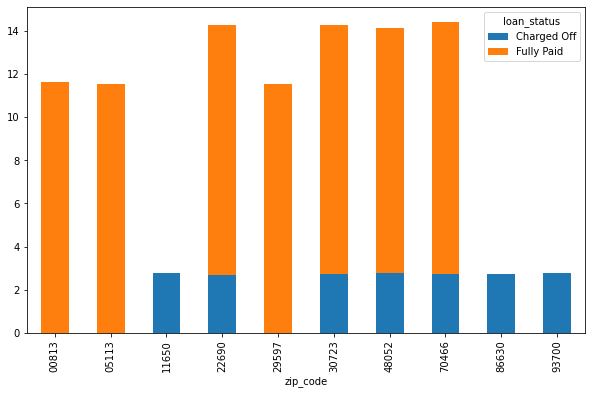

In [50]:
zip_status.plot(kind = 'bar', stacked = True, figsize = (10,6))

- Zip codes such as 11650, 86630 and 93700 have 100% defaulters

In [51]:
state_status = pd.crosstab(df['state'],df['loan_status'],normalize = 'index') * 100

<AxesSubplot:xlabel='state'>

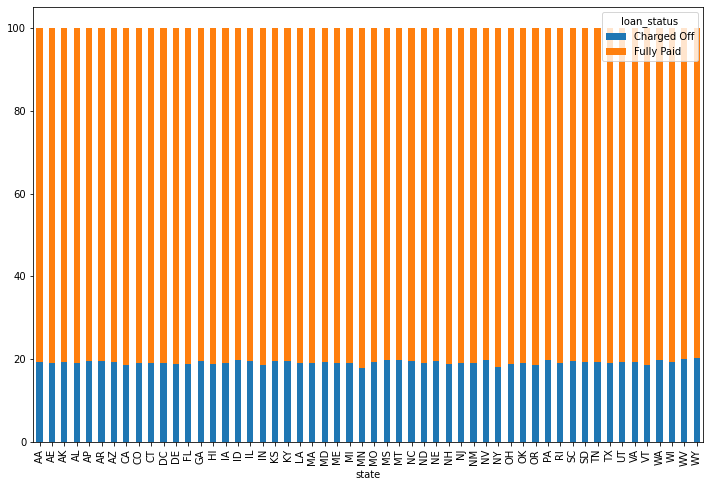

In [52]:
state_status.plot(kind = 'bar', stacked = True, figsize = (12,8))

In [53]:
# Remove columns which do not have an impact on loan_status
df.drop(columns=['initial_list_status','state',
                 'emp_title', 'title','earliest_cr_line',
                 'issue_d','sub_grade','address','pub_rec_bankruptcies','mort_acc','pub_rec'], inplace=True)

# Subgrade is removed because grade and subgrade are similar features

### 7. Outlier detection and treatment

In [54]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_flag', 'mort_acc_flag',
       'pub_rec_bankruptcies_flag'],
      dtype='object')

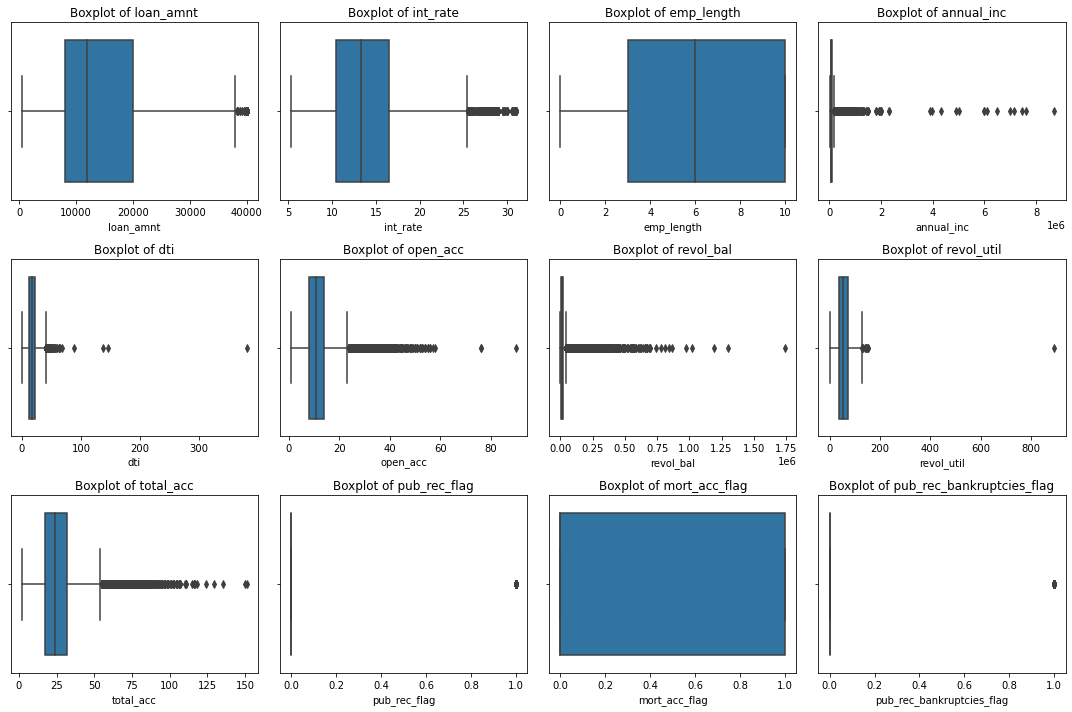

In [55]:
plt.figure(figsize=(15, 10))

# Loop through each variable and create a boxplot
for i, var in enumerate(num_cols):
    plt.subplot(3, 4, i+1)  # Create subplots in a 3x4 grid
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    #plt.yscale('log')
    
plt.tight_layout()
plt.show()

#### 1. **loan_amnt**
   - **Range**: Most loan amounts are between approximately 5,000 and 25,000.
   - **Outliers**: There are a few high-value loans around 35,000 to 40,000, which are outliers.

#### 2. **int_rate** (Interest Rate)
   - **Range**: The majority of interest rates fall between 10% and 20%.
   - **Outliers**: A few outliers go beyond 25%, indicating loans with significantly higher interest rates.

#### 3. **emp_length** (Employment Length)
   - **Range**: Employment length mostly ranges from 0 to 10 years, with no outliers.
   - **Outliers**: There are no significant outliers, but the plot suggests that most borrowers have less than 10 years of employment history.

#### 4. **annual_inc** (Annual Income)
   - **Range**: Most annual incomes fall below 200,000.
   - **Outliers**: Significant outliers, with a few going up to 800,000 or beyond, suggesting high-income borrowers.

#### 5. **dti** (Debt-to-Income Ratio)
   - **Range**: Most values are below 50.
   - **Outliers**: There are outliers above 100, suggesting some borrowers have extremely high debt relative to their income, which could be a risk factor.

#### 6. **open_acc** (Open Credit Accounts)
   - **Range**: The majority have fewer than 20 open accounts.
   - **Outliers**: Some borrowers have between 40 and 80 open accounts, indicating potentially high credit activity.

#### 7. **revol_bal** (Revolving Balance)
   - **Range**: Most revolving balances are below 100,000.
   - **Outliers**: Some balances reach up to 1.5 million, indicating substantial revolving credit for certain borrowers.

#### 8. **revol_util** (Revolving Utilization)
   - **Range**: Most utilization rates are below 100%, with many between 0 and 50%.
   - **Outliers**: There are a few cases above 100%, suggesting over-utilization, which could indicate financial strain.

#### 9. **total_acc** (Total Accounts)
   - **Range**: Most borrowers have fewer than 50 total credit accounts.
   - **Outliers**: Some individuals have over 100 accounts, which could imply high credit usage over time.

#### 10. **pub_rec_flag** and **pub_rec_bankruptcies_flag**
   - **Range**: These are binary flags, mostly at 0, indicating that most borrowers have no public record flags or bankruptcies.
   - **Outliers**: A few instances show values of 1, indicating some borrowers with past public records or bankruptcies.

#### 11. **mort_acc_flag**
   - **Range**: Appears mostly binary, with most values being 1.
   - **Outliers**: No significant outliers, but the presence of this flag could indicate mortgage-related data..

In [56]:
# Before capping
print("Before Capping:")
print("Max:", df['loan_amnt'].max())
print("Min:", df['loan_amnt'].min())

Before Capping:
Max: 40000.0
Min: 500.0


In [57]:
columns_to_cap = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_flag', 'mort_acc_flag',
       'pub_rec_bankruptcies_flag']
# Function to cap outliers at specified percentiles
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower = df[column].quantile(lower_percentile)
    upper = df[column].quantile(upper_percentile)
    df[column] = np.where(df[column] < lower, lower, df[column])
    df[column] = np.where(df[column] > upper, upper, df[column])
    return df

# Apply capping to each specified column
for col in num_cols:
    df = cap_outliers(df, col, 0.01, 0.95)

In [58]:
#df['loan_amnt_log'] = np.log1p(df['loan_amnt'])  
df['annual_inc_log'] = np.log1p(df['annual_inc']) # log(1 + x) to handle zero values

In [59]:
# After capping
print("After Capping:")
print("Max:", df['loan_amnt'].max())
print("Min:", df['loan_amnt'].min())

After Capping:
Max: 31200.0
Min: 1600.0


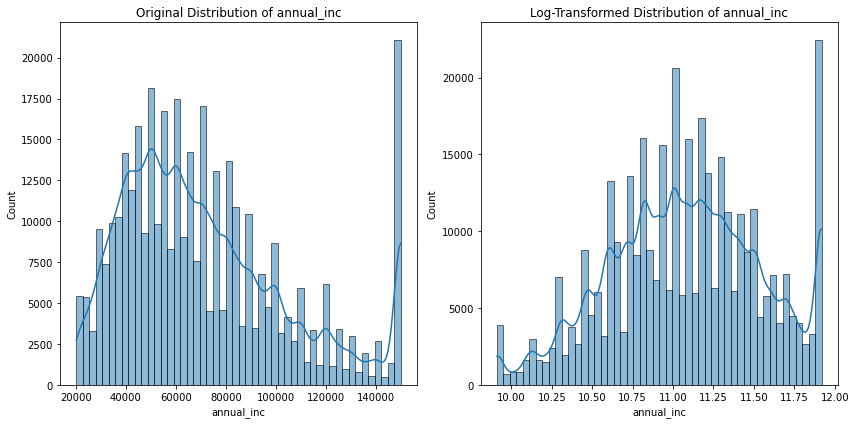

In [60]:
log_transform = ['annual_inc']
for col in log_transform:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Original Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df[col]), bins=50, kde=True)
    plt.title(f'Log-Transformed Distribution of {col}')
    
plt.tight_layout()    
plt.show()

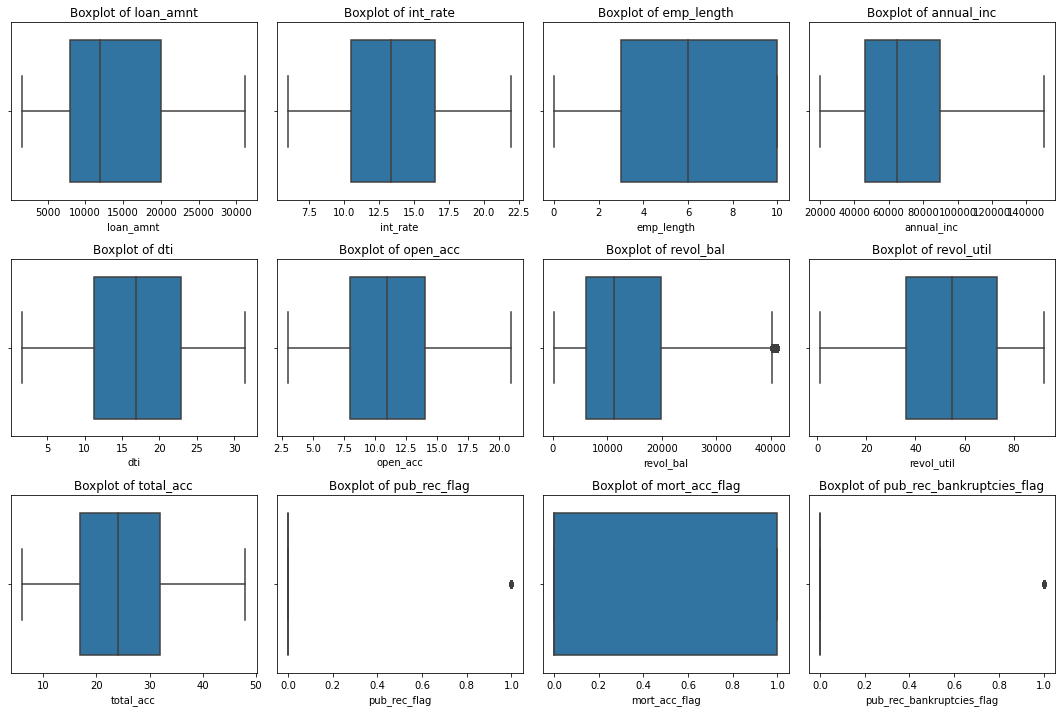

In [61]:
plt.figure(figsize=(15, 10))
# Loop through each variable and create a boxplot
for i, var in enumerate(num_cols):
    plt.subplot(3, 4, i+1)  # Create subplots in a 3x4 grid
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    #plt.yscale('log')
    
plt.tight_layout()
plt.show()

For this case study, using capping and log transformation can be an effective approach instead of removing outliers. Here’s why:

1. **Capping for Extreme Outliers**: Instead of removing outliers, capping limits extreme values to a defined range (e.g., 95th percentile). This retains the data while mitigating the influence of outliers that might distort model performance, particularly for financial variables like income or loan amounts.
   
2. **Log Transformation for Skewed Data**: Log transformation is suitable for skewed distributions, common in financial datasets. It compresses the range of values, normalizing heavy-tailed distributions (e.g., annual income) while preserving relationships in the data.

3. **Retaining Data Volume**: Removing too many rows through outlier removal could lead to information loss, especially in cases where outliers might still hold valuable insights for creditworthiness or risk prediction.

By applying these methods, we can maintain a more complete dataset while ensuring that extreme values don't disproportionately affect our analysis.

In [62]:
#droping annual_inc as we have annual_inc_log
df.drop(columns = ['annual_inc'],inplace =True)

In [63]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'purpose',
       'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'application_type', 'pub_rec_flag', 'mort_acc_flag',
       'pub_rec_bankruptcies_flag', 'zip_code', 'annual_inc_log'],
      dtype='object')

In [64]:
#implemnt using one-hot-encoder from sklearn
#columns = ['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership'] 

In [65]:
df['term'].unique()

[' 36 months', ' 60 months']
Categories (2, object): [' 36 months', ' 60 months']

In [66]:
df['term'].shape

(370622,)

In [67]:
df['term'] = df['term'].map({' 36 months' : 36, ' 60 months' : 60})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370622 entries, 0 to 396029
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_amnt                  370622 non-null  float64 
 1   term                       370622 non-null  category
 2   int_rate                   370622 non-null  float64 
 3   grade                      370622 non-null  category
 4   emp_length                 370622 non-null  float64 
 5   home_ownership             370622 non-null  category
 6   verification_status        370622 non-null  category
 7   loan_status                370622 non-null  category
 8   purpose                    370622 non-null  category
 9   dti                        370622 non-null  float64 
 10  open_acc                   370622 non-null  float64 
 11  revol_bal                  370622 non-null  float64 
 12  revol_util                 370622 non-null  float64 
 13  total_acc     

In [68]:
# Encoding Target Variable

df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1}).astype(int)

In [69]:
df.shape

(370622, 20)

In [70]:
#bifurcating independent and dependent variable
x = df.drop(columns=['loan_status'])
y = df['loan_status']

In [71]:
x.shape

(370622, 19)

### 8. Encoding

In [72]:
# Drop rows with missing values in any of the encoding columns before fitting the encoder
encode_columns = ['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership'] 
x = x.dropna(subset=encode_columns)
y = y.loc[x.index]  # Keep the corresponding target values

In [73]:

# Define the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)  # 'drop="first"' to avoid dummy variable trap

# Fit and transform the categorical columns
x_encoded = encoder.fit_transform(x[encode_columns])

# Convert the result into a DataFrame
x_encoded = pd.DataFrame(x_encoded, columns=encoder.get_feature_names_out(encode_columns))

# Concatenate the new encoded DataFrame with the original x
x = pd.concat([x.reset_index(drop=True), x_encoded.reset_index(drop=True)], axis=1)

# Drop the original categorical columns
x.drop(columns=encode_columns, inplace=True)

In [74]:
x.shape

(370622, 50)

### 9. Train-test split

In [75]:
if x.shape[0] != y.shape[0]:
    print("Mismatch found: ", x.shape[0], "in x and", y.shape[0], "in y")

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,stratify=y,random_state=42)

In [77]:
print(f'x_train: {x_train.shape} y_train: {y_train.shape}')
print(f'x_test:  {x_test.shape}   y_test: {y_test.shape}')

x_train: (296497, 50) y_train: (296497,)
x_test:  (74125, 50)   y_test: (74125,)


### 10. Scaling Numeric Features

In [78]:
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

#balancing dataset
Summary of Steps:
Train a Model on the Original Imbalanced Dataset:

Obtain baseline performance metrics.
Understand the impact of class imbalance.
Balance the Training Dataset Using Techniques like SMOTE:

Generate synthetic samples for the minority class.
Retrain the model using the balanced dataset.
Evaluate the Model on the Original Imbalanced Test Set:

Check performance metrics to see how well the model generalizes to real-world data.

## Logistic Regression

In [79]:
#baseline model training
model = LogisticRegression() #initialization
#model 1 without balancing
model.fit(x_train, y_train)

LogisticRegression()

In [80]:
#predicting on train and test sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [81]:
#Model Evaluation for training set
print('Train Accuracy :', model.score(x_train, y_train))
print('Train F1 Score:',f1_score(y_train,y_train_pred))
print('Train Recall Score:',recall_score(y_train,y_train_pred))
print('Train Precision Score:',precision_score(y_train,y_train_pred))

Train Accuracy : 0.8912670279969106
Train F1 Score: 0.6185320601564256
Train Recall Score: 0.45849559695470654
Train Precision Score: 0.9501944959464863


In [82]:
#Model Evaluation for testing set
print('\nTest Accuracy :',model.score(x_test,y_test))
print('Test F1 Score:',f1_score(y_test,y_test_pred))
print('Test Recall Score:',recall_score(y_test,y_test_pred))
print('Test Precision Score:',precision_score(y_test,y_test_pred))


Test Accuracy : 0.8921011804384485
Test F1 Score: 0.6222012281530468
Test Recall Score: 0.46211058097109176
Test Precision Score: 0.9520092512286789


In [83]:
# Oversampling to balance the target variable

sm=SMOTE(random_state=42)
x_train_bal, y_train_bal = sm.fit_resample(x_train,y_train)

In [84]:
print(f"Before OverSampling, count of label 1: {sum(y_train == 1)}")
print(f"Before OverSampling, count of label 0: {sum(y_train == 0)}")
print(f"After OverSampling, count of label 1: {sum(y_train_bal == 1)}")
print(f"After OverSampling, count of label 0: {sum(y_train_bal == 0)}")

Before OverSampling, count of label 1: 57006
Before OverSampling, count of label 0: 239491
After OverSampling, count of label 1: 239491
After OverSampling, count of label 0: 239491


In [85]:
# model 2 after balancing target variable
model.fit(x_train_bal, y_train_bal)

LogisticRegression()

In [86]:
#predicting on train and test sets
y_train_bal_pred = model.predict(x_train_bal)
y_test_bal_pred = model.predict(x_test)

In [87]:
#Model Evaluation for training set
print('Train Accuracy :', model.score(x_train_bal, y_train_bal))
print('Train F1 Score:',f1_score(y_train_bal,y_train_bal_pred))
print('Train Recall Score:',recall_score(y_train_bal,y_train_bal_pred))
print('Train Precision Score:',precision_score(y_train_bal,y_train_bal_pred))

Train Accuracy : 0.8071138372631957
Train F1 Score: 0.8090635352664852
Train Recall Score: 0.8173250769339975
Train Precision Score: 0.8009673380199851


In [88]:
#Model Evaluation for testing set
print('\nTest Accuracy :',model.score(x_test,y_test))
print('Test F1 Score:',f1_score(y_test,y_test_bal_pred))
print('Test Recall Score:',recall_score(y_test,y_test_bal_pred))
print('Test Precision Score:',precision_score(y_test,y_test_bal_pred))


Test Accuracy : 0.799433389544688
Test F1 Score: 0.60792742424642
Test Recall Score: 0.8087285994948078
Test Precision Score: 0.48700722525034856


In [89]:
print(classification_report(y_test, y_test_bal_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     59873
           1       0.49      0.81      0.61     14252

    accuracy                           0.80     74125
   macro avg       0.72      0.80      0.74     74125
weighted avg       0.86      0.80      0.82     74125



In [90]:
from sklearn.model_selection import GridSearchCV

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.1,1, 5]  # Regularization strength
    
}

# Set up the grid search
grid_search = GridSearchCV(model, param_grid, scoring='precision')
grid_search.fit(x_train_bal, y_train_bal)

# Get the best model
best_model = grid_search.best_estimator_


In [91]:
best_model

LogisticRegression(C=0.1, max_iter=1000)

In [92]:
model_3 = LogisticRegression(C=0.1, max_iter=1000) #initialization
model_3.fit(x_train_bal, y_train_bal)

LogisticRegression(C=0.1, max_iter=1000)

In [93]:
#predicting on train and test sets
y_train_bal_pred_3 = model_3.predict(x_train_bal)
y_test_bal_pred_3= model_3.predict(x_test)

In [94]:
#Model Evaluation for training set
print('Train Accuracy :', model_3.score(x_train_bal, y_train_bal))
print('Train F1 Score:',f1_score(y_train_bal,y_train_bal_pred_3))
print('Train Recall Score:',recall_score(y_train_bal,y_train_bal_pred_3))
print('Train Precision Score:',precision_score(y_train_bal,y_train_bal_pred_3))

Train Accuracy : 0.8068152874220743
Train F1 Score: 0.8086988162034989
Train Recall Score: 0.8166611688956996
Train Precision Score: 0.8008902283718321


In [95]:
#Model Evaluation for testing set
print('\nTest Accuracy :',model_3.score(x_test,y_test))
print('Test F1 Score:',f1_score(y_test,y_test_bal_pred_3))
print('Test Recall Score:',recall_score(y_test,y_test_bal_pred_3))
print('Test Precision Score:',precision_score(y_test,y_test_bal_pred_3))


Test Accuracy : 0.7995682967959528
Test F1 Score: 0.6082324710597791
Test Recall Score: 0.8092197586303677
Test Precision Score: 0.4872206497401884


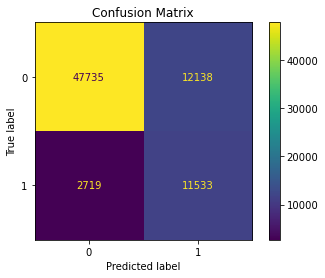

In [96]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_bal_pred_3)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

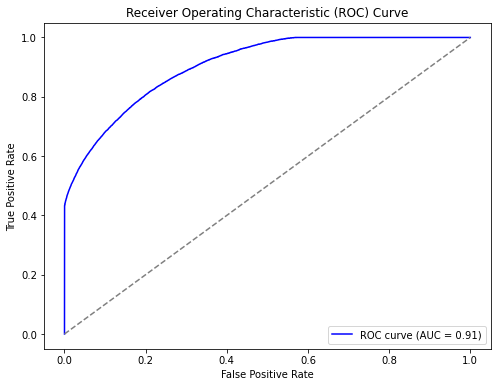

In [97]:
# Predict probabilities
y_pred_proba1 = model_3.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1)
roc_auc = roc_auc_score(y_test, y_pred_proba1)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

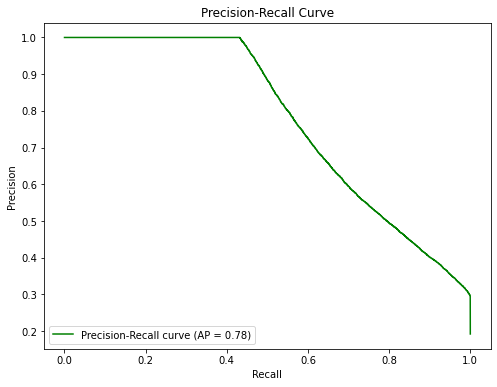

In [98]:
# Calculate Precision-Recall curve and Average Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba1)
avg_precision = average_precision_score(y_test, y_pred_proba1)

# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### ROC-AUC Curve
1. **High AUC (0.91)**: Indicates strong model performance in distinguishing between fully paid loans and defaults.
2. **Curve Shape**: Approaches the top-left corner, suggesting the model maintains high True Positive Rates with low False Positive Rates.
3. **Insight**: The high AUC score reflects the model's reliability and good discriminatory power, making it suitable for loan approval decision-making.

### Precision-Recall Curve
1. **Average Precision (0.78)**: Reflects a good balance between identifying true positives (Recall) and minimizing false positives (Precision).
2. **Trade-off**: As Recall increases, Precision decreases, highlighting a typical trade-off in imbalanced datasets.
3. **Insight**: Threshold adjustment can optimize for either high Precision (reducing false positives) or high Recall (capturing more true positives) based on the bank’s risk tolerance and priorities.

In [99]:
x.columns

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_flag', 'mort_acc_flag',
       'pub_rec_bankruptcies_flag', 'annual_inc_log', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
       'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_own

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = [
    'loan_amnt', 'term', 'int_rate', 'emp_length', 'dti', 'open_acc',
    'revol_bal', 'revol_util', 'total_acc', 'pub_rec_flag', 'mort_acc_flag',
    'pub_rec_bankruptcies_flag', 'annual_inc_log', 'purpose_credit_card',
    'purpose_debt_consolidation', 'purpose_educational',
    'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
    'purpose_medical', 'purpose_moving', 'purpose_other',
    'purpose_renewable_energy', 'purpose_small_business',
    'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
    'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
    'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700',
    'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
    'verification_status_Source Verified', 'verification_status_Verified',
    'application_type_INDIVIDUAL', 'application_type_JOINT',
    'home_ownership_MORTGAGE', 'home_ownership_NONE',
    'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'
]



# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF
vif_results = calculate_vif(x)

print(sorted(vif_results))


['Feature', 'VIF']


In [101]:
vif_results.sort_values(by='VIF', ascending = False)[:10]

,Feature,VIF
43,application_type_INDIVIDUAL,1512.098875
45,home_ownership_MORTGAGE,1355.169219
49,home_ownership_RENT,1091.635416
12,annual_inc_log,1067.320242
48,home_ownership_OWN,243.186825
2,int_rate,130.321420
14,purpose_debt_consolidation,52.500265
1,term,26.916140
13,purpose_credit_card,19.072759
5,open_acc,15.845690


- Drop Features with High VIF:

- Retain Important Features:

  - Keep features with significant absolute coefficients, such as annual_inc_log and int_rate, as they show strong influence.
- Refine Feature Set:

  - Create a refined feature set by dropping or combining multicollinear features based on domain knowledge and VIF results.
- Retrain and Re-evaluate the Model:

  - After refining the feature set, retrain your model and check the VIF and performance metrics again to ensure improvements.

In [102]:
# Drop features with high VIF
features_to_drop = ['application_type_INDIVIDUAL', 'home_ownership_MORTGAGE', 'home_ownership_RENT','home_ownership_OWN','purpose_debt_consolidation']
X_train_refined = x_train_bal.drop(columns=features_to_drop)
X_test_refined = x_test.drop(columns=features_to_drop)

In [103]:
#retrain model
model_3 = LogisticRegression(C=0.1, max_iter=1000)
model_3.fit(X_train_refined,y_train_bal)

LogisticRegression(C=0.1, max_iter=1000)

In [104]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_refined.columns,  # Get the feature names
    'Coefficient': model_3.coef_.ravel()  
})

# Sort the DataFrame by absolute value of coefficients for better interpretation
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance)

                                Feature  Coefficient  Importance
33                       zip_code_93700    10.283145   10.283145
26                       zip_code_11650    10.275589   10.275589
32                       zip_code_86630    10.225907   10.225907
30                       zip_code_48052     4.438567    4.438567
29                       zip_code_30723     4.391750    4.391750
27                       zip_code_22690     4.388299    4.388299
31                       zip_code_70466     4.385475    4.385475
28                       zip_code_29597    -2.824485    2.824485
25                       zip_code_05113    -2.816516    2.816516
42               application_type_JOINT    -1.564371    1.564371
39                              grade_G     1.369629    1.369629
38                              grade_F     1.303323    1.303323
37                              grade_E     1.247559    1.247559
36                              grade_D     1.097725    1.097725
12                       

In [105]:
#predicting on train and test sets
y_train_bal_pred_3 = model_3.predict(X_train_refined)
y_test_bal_pred_3= model_3.predict(X_test_refined)

In [106]:
#Model Evaluation for training set
print('Train Accuracy :', model_3.score(X_train_refined, y_train_bal))
print('Train F1 Score:',f1_score(y_train_bal,y_train_bal_pred_3))
print('Train Recall Score:',recall_score(y_train_bal,y_train_bal_pred_3))
print('Train Precision Score:',precision_score(y_train_bal,y_train_bal_pred_3))
print()
#Model Evaluation for testing set
print('\nTest Accuracy :',model_3.score(X_test_refined,y_test))
print('Test F1 Score:',f1_score(y_test,y_test_bal_pred_3))
print('Test Recall Score:',recall_score(y_test,y_test_bal_pred_3))
print('Test Precision Score:',precision_score(y_test,y_test_bal_pred_3))

Train Accuracy : 0.8067568301105261
Train F1 Score: 0.8086258942232146
Train Recall Score: 0.8165233766613359
Train Precision Score: 0.8008797185555906


Test Accuracy : 0.7984350758853288
Test F1 Score: 0.6061005510005009
Test Recall Score: 0.8065534661801852
Test Precision Score: 0.4854512437180624


In [107]:
y_prob = model_3.predict_proba(X_test_refined)[:, 1]  # Probability of positive class

# Adjust the threshold
new_threshold = 0.543  # Example: Increase the threshold to 0.6

# Make predictions based on the new threshold
y_pred_adjusted = (y_prob >= new_threshold).astype(int)

# Evaluate precision and recall
new_precision = precision_score(y_test, y_pred_adjusted)
new_recall = recall_score(y_test, y_pred_adjusted)

print('New Precision:', new_precision.round(2))
print('New Recall:', new_recall.round(2))
print('Test F1 Score:',f1_score(y_test,y_pred_adjusted).round(2))

New Precision: 0.53
New Recall: 0.77
Test F1 Score: 0.63


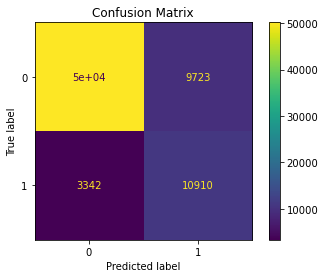

In [108]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

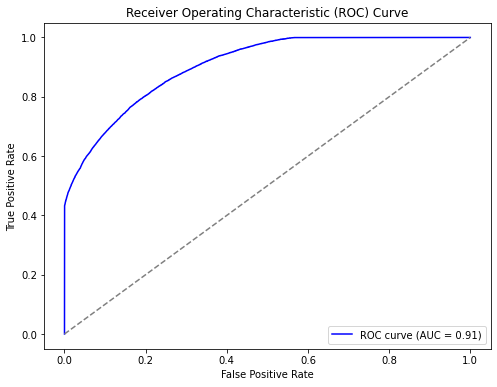

In [109]:
# Predict probabilities
#y_pred_proba1 = model_3.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

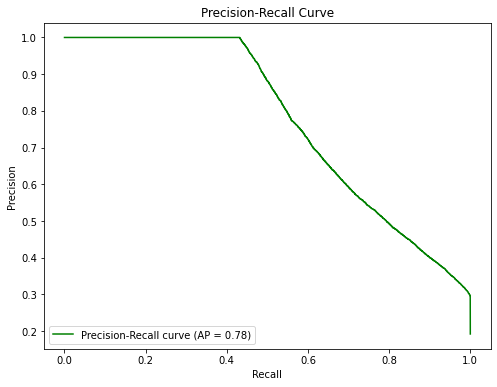

In [110]:
# Calculate Precision-Recall curve and Average Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Plotting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### ROC-AUC Curve
1. **High AUC (0.91)**: Indicates strong model performance in distinguishing between fully paid loans and defaults.
2. **Curve Shape**: Approaches the top-left corner, suggesting the model maintains high True Positive Rates with low False Positive Rates.
3. **Insight**: The high AUC score reflects the model's reliability and good discriminatory power, making it suitable for loan approval decision-making.

### Precision-Recall Curve
1. **Average Precision (0.78)**: Reflects a good balance between identifying true positives (Recall) and minimizing false positives (Precision).
2. **Trade-off**: As Recall increases, Precision decreases, highlighting a typical trade-off in imbalanced datasets.
3. **Insight**: Threshold adjustment can optimize for either high Precision (reducing false positives) or high Recall (capturing more true positives) based on the bank’s risk tolerance and priorities.

### Final Inferences 

1. **Dataset Overview**:
   - The dataset consists of **396,030 records**, with **27 features**, including the target variable `loan_status`.
   - Distribution of the target variable:
     - **80% of loans** are classified as "Fully Paid" (class 0).
     - **20% of loans** are classified as "Charged Off" (class 1), indicating defaults.<br><br>

2. **Class Imbalance and Data Preparation**:
   - The dataset shows a significant class imbalance, which was addressed using **SMOTE (Synthetic Minority Oversampling Technique)**. This approach effectively balanced the dataset.<br><br>

3. **Loan Amount Analysis**:
   - The median loan amount is slightly **higher** for "Charged Off" loans, suggesting that larger loan amounts carry a higher risk of default.<br><br>

4. **Impact of Loan Term**:
   - Loans with a **60-month term** have a higher probability of default compared to 36-month loans, indicating longer repayment periods are riskier.<br><br>

5. **Interest Rate Analysis**:
   - The mean and median interest rates are **higher** for defaulted loans, reflecting the higher risk profile of these borrowers.<br><br>

6. **Loan Grades and Sub-Grades**:
   - Lower loan grades (**E, F, and G**) show significantly higher default probabilities, with the **G grade** having the highest risk.
   - Sub-grades exhibit a similar trend, where lower sub-grades are associated with a higher likelihood of default.<br><br>

7. **Employment Length Analysis**:
   - Employment length is a strong indicator of creditworthiness, and longer employment tenure correlates with better loan repayment behavior.<br><br>

8. **Home Ownership Status**:
   - Borrowers who **rent** show a higher probability of default, while those with mortgages or who own homes have a lower default risk.
   - This suggests that home ownership is an indicator of financial stability.<br><br>

9. **Annual Income**:
   - The median annual income is slightly higher for borrowers who have fully paid their loans. However, high-income borrowers are also present among defaulters, indicating income alone may not be a reliable predictor.<br><br>

10. **Loan Purpose Analysis**:
    - The most common loan purposes are **debt consolidation** and **credit card refinancing**.
    - Borrowers seeking loans for **small business purposes** exhibit a higher probability of default, indicating higher risk in this segment.<br><br>

11. **Debt-to-Income (DTI) Ratio and Credit Utilization**:
    - The **DTI ratio** is higher for defaulters, suggesting higher financial burdens relative to income.
    - **Revolving credit utilization** rates are also higher for defaulters, indicating potential over-leverage and financial strain.<br><br>

12. **Public Records and Bankruptcy**:
    - An increase in the number of **derogatory public records** (e.g., bankruptcies) strongly correlates with a higher likelihood of default.<br><br>

13. **Handling Missing Data and Outliers**:
    - Missing values were imputed using median values, and outliers were handled through **capping** and **log transformation**. This approach preserved the data integrity and minimized information loss.<br><br>

14. **Model Evaluation and Key Features**:
    - Logistic Regression was used as the primary model. Important predictive features include:
      - **Loan Grade**
      - **Interest Rate**
      - **Debt-to-Income Ratio**
      - **Home Ownership Status**
      - **Zip code**<br><br>

15. **ROC-AUC Performance**:
    - The model achieved a **ROC-AUC score of 0.91**, indicating strong discriminatory power. This high score suggests the model is effective in distinguishing between fully paid and defaulted loans.<br><br>

###  Actionable Insights & Recommendations

1. **Focus on Precision for Profit Maximization**:
   - As an NBFC, LoanTap should prioritize **precision** over recall. High precision reduces false positives (incorrectly predicting defaults), ensuring more eligible borrowers receive loans and maximizing interest revenue.<br><br>

2. **Adopt a Balanced Approach with Threshold Adjustment**:
   - Consider adjusting the prediction threshold based on risk tolerance. This balanced approach helps control the trade-off between approving more loans and minimizing default risks, essential for optimizing NBFC profitability.<br><br>

3. **Strengthen Verification Processes**:
   - Review the income verification process, as verified borrowers showed higher default rates. Enhanced due diligence may help reduce discrepancies and identify high-risk borrowers.<br><br>

4. **Implement Stricter Lending Policies for Renters**:
   - Borrowers who rent have a higher likelihood of default. Stricter lending criteria or additional collateral requirements could mitigate this risk.<br><br>

5. **Monitor High DTI Borrowers and Offer Financial Support**:
   - High DTI borrowers should be monitored closely. Consider offering debt counseling or consolidation options to alleviate financial strain.<br><br>

6. **Leverage Public Record Data for Risk Assessment**:
   - Incorporate the number of derogatory public records as a key factor in credit risk evaluation, as it is a strong indicator of default risk.<br><br>

7. **Adjust Loan Terms Based on Risk**:
   - Limit approvals for **60-month term loans** or adjust interest rates for longer terms to compensate for the higher risk.<br><br>

8. **Continuous Model Monitoring and Updating**:
   - To maintain model effectiveness, LoanTap should implement continuous monitoring through a performance dashboard, periodic retraining, and drift detection to adapt to new data and business changes. Additionally, incorporating a feedback loop with the credit risk team and adjusting prediction thresholds based on business goals will enhance the model’s alignment with real-world needs and improve decision-making accuracy.<br><br>

9. **Utilize High ROC-AUC Score in Credit Decision-Making**:
   - The high ROC-AUC score indicates strong model reliability. Use this performance metric to justify model-driven decisions and enhance credit approval strategies.



 2. CommentaboutthecorrelationbetweenLoanAmountandInstallmentfeatures.
 3. Themajorityofpeoplehavehomeownershipas
  4. Peoplewithgrades‘A’aremorelikelytofullypaytheirloan.(T/F
  Namethetop2affordedjobtitles.
  
  6. Thinking from a bank's perspective, which metric should our primary focus be on.. ROC AUC, Precision, Recall, F1 Score
   7. How does the gap in precision and recall affect the bank?
    8. Which were the features that heavily affected the outcome?
    
  9. Will the results be affected by geographical location? (Yes/No)